In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam,RMSprop
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
np.random.seed(42)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle


pickle_in = open("/content/drive/My Drive/newlyrics.txt", "rb")
texts = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/newgenre.txt", "rb")
labels = pickle.load(pickle_in)

print("text size: %g" %len(texts))
print()
print("label size: %g" %len(labels))

from sklearn.preprocessing import LabelEncoder
# converts the character array to numeric array. Assigns levels to unique labels.

le = LabelEncoder() 
le.fit(labels)
labels = le.transform(labels)


print(le.classes_)
print(np.unique(labels, return_counts=True))


text size: 44195

label size: 44195
['Country' 'Hip-Hop' 'Metal' 'Pop' 'Rock']
(array([0, 1, 2, 3, 4]), array([8839, 8839, 8839, 8839, 8839]))


In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(texts)

In [0]:
vocab_size=len(tokenizer.index_word)

sequence_length=1000

data = dict()

data["vocab_size"] = vocab_size

data["sequence_length"] = sequence_length

data["texts"] = texts

data["labels"] = labels

In [0]:
def tokenize_text(data):
    tokenizer = Tokenizer(num_words=data["vocab_size"])
    tokenizer.fit_on_texts(data["texts"])
    data["tokenizer"] = tokenizer
    sequences = tokenizer.texts_to_sequences(data["texts"])

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data["X"] = pad_sequences(sequences, maxlen=data["sequence_length"])
    data["y"] = to_categorical(np.asarray(data["labels"]))
    print('Shape of data tensor:', data["X"].shape)
    print('Shape of label tensor:', data["y"].shape)

    # texts and labels aren't needed anymore
    data.pop("texts", None)
    data.pop("labels", None)
    return data
  
  
data = tokenize_text(data)



Found 185131 unique tokens.
Shape of data tensor: (44195, 1000)
Shape of label tensor: (44195, 5)


In [0]:
def train_val_test_split(data):

    data["X_train"], X_test_val, data["y_train"],  y_test_val = train_test_split(data["X"], data["y"], test_size=0.25)
    data["X_val"], data["X_test"], data["y_val"], data["y_test"] = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return data

data = train_val_test_split(data)  
data["embedding_dim"] = 100

In [0]:
filter_sizes = [3,4,5]
num_filters = 32
drop = 0.5

def build_model(vocab_size, embedding_dim, sequence_length):
    sequence_input = Input(shape=(sequence_length,), dtype='int32')
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=sequence_length,
                                name="embedding")(sequence_input)
    
    reshape = Reshape((sequence_length,embedding_dim,1))(embedding_layer)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    
    maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
    
    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=5, activation='softmax')(dropout)
    
    model = Model(inputs=sequence_input, outputs=output)
    
    adam=RMSprop(lr=5e-3,rho=0.9,decay=0.01)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model
  
  
  
model = build_model(vocab_size=data["vocab_size"], embedding_dim=data['embedding_dim'], sequence_length=data['sequence_length'])

print(model.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(data["X_train"], data["y_train"], batch_size=32, epochs=50, callbacks=callbacks, validation_data=(data["X_val"], data["y_val"]))

model.save("nusicGenre_model_word_embedding.h5")

score, acc = model.evaluate(x=data["X_test"], y=data["y_test"],batch_size=128)






Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 100)    18513100    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1000, 100, 1) 0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

In [0]:
print(acc)

0.6470588235833526


In [0]:

#predictions on test data

predicted=model.predict(data["X_test"])
predicted

#model evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(data["y_test"], predicted.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print("############################")

print(sklearn.metrics.classification_report(data["y_test"], predicted.round()))

precision: [0.75595914 0.8893485  0.80314136 0.5904     0.56170213]
recall: [0.58267717 0.76106195 0.71084337 0.33637192 0.12267658]
fscore: [0.65810277 0.82021936 0.75417896 0.42857143 0.201373  ]
support: [1143 1130 1079 1097 1076]
############################
              precision    recall  f1-score   support

           0       0.76      0.58      0.66      1143
           1       0.89      0.76      0.82      1130
           2       0.80      0.71      0.75      1079
           3       0.59      0.34      0.43      1097
           4       0.56      0.12      0.20      1076

   micro avg       0.76      0.51      0.61      5525
   macro avg       0.72      0.50      0.57      5525
weighted avg       0.72      0.51      0.58      5525
 samples avg       0.51      0.51      0.51      5525



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


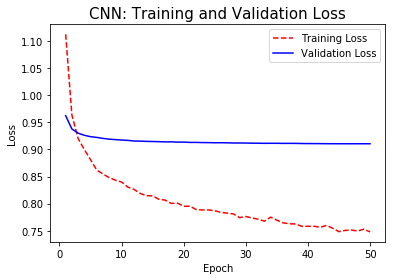

In [0]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.title('CNN: Training and Validation Loss',fontsize=15)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('CNN-VAL&TRAINING-LOSS.png')
plt.show();

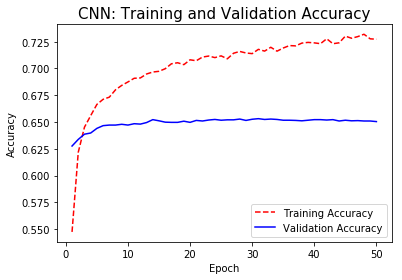

In [0]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['acc']
test_loss = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.title('CNN: Training and Validation Accuracy',fontsize=15)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('CNN-VAL&TRAINING-Accuracy.png')
plt.show();

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    
    plt.xlabel('Epochs')
    plt.title('CNN: Training and Validation Loss',fontsize=15)
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('CRNN_VAL&TRAINING_LOSS.png')
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    
    plt.xlabel('Epochs')
    plt.title('CNN: Training and Validation Accuracy',fontsize=15)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('CNN_VAL&TRAINING_ACC.png')
    plt.show()
   

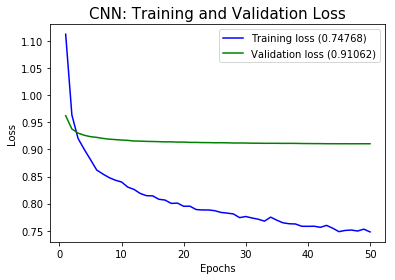

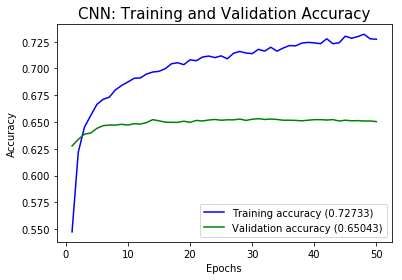

In [0]:
plot_history(history)

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)